In [2]:
from src.databases.trajectory_analysis_script import *
from scipy.interpolate import griddata
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import gaussian_kde
import pandas as pd
import os
import numpy as np
from src.helpers.plotting_functions import *
from src.helpers.import_functions import *
from src.helpers.Analysis_functions import *
from src.helpers.diff_mw import *
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib as mpl
from src.helpers.scalebars import *
from src.helpers.Convert_csv_mat import *
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy import stats, ndimage,io
from skimage import io as skio
import csv  
from sklearn.cluster import OPTICS
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')  
from sklearn.cluster import DBSCAN
from cgitb import small
import src.helpers.smallestenclosingcircle as smallestenclosingcircle
import math
import src.helpers.guassian_fit as gaussian_fit
import src.helpers.fbm_utility as fbm_utility
import src.helpers.simulate_foci as simulate_foci
import src.helpers.simulate_cells as simulate_cells
import src.helpers.SMT_converters as smt
import matplotlib.patches as mpatches
import pickle
from warnings import filterwarnings
filterwarnings('ignore')

/var/folders/_t/qlzp5l894v16vmr8m_81x5x80000gn/T/ipykernel_7829/2213217539.py:35: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [3]:
globals = {"olympus_pixel_size":130,"confocal_pixel_size":79}

analysis of some confocal images

In [4]:
#find files
def find_files(path, extension, keyword = None):
    '''
    Docstring for find_files
    Finds files in a directory with a specific extension and keyword in the name

    Parameters:
    -----------
    path : str
        path to the directory where the files are located
    extension : str
        extension of the files to be found
    keyword : str    
        keyword to be searched in the file name
    Returns:
    --------
    files : list
        list of files that match the criteria
    '''
    #find all images in the directory using import functions
    files = find_image(path=path,ends_with=extension,full_path=True)
    #sort the files to get only ones conatining the word "RFP" for the flourescent protein
    files = name_sorter(strings=files,keyword=keyword)
    return files

In [5]:
#run detection on a set of files 
def utility_batch_blob_detection(files,detection_args,fitting_args,focal_plane=None,project=False,plot=False):
    '''
    Docstring for utility_batch_blob_detection
    Runs blob detection on a set of files and returns the blobs in a list

    Parameters:
    -----------
    files : list
        list of files to be analyzed
    detection_args : dict
        dictionary of arguments for the blob detection
    fitting_args : dict 
        dictionary of arguments for the blob fitting
    focal_plane : int
        focal plane to be analyzed in each image (default is None if there is only one plane)
    project : bool
        whether or not to project the image using max (default is False), focal_plane must be None if project is True
    plot : bool
        whether or not to plot the blobs on the image (default is False)

    Returns:
    --------
    blobs : list
        list of blobs detected in each image aggregated in a list
    
    Notes:
    ------
    This doesn't care if the detection is verbose, the list may be a list of lists or a list of dictionaries, see blob_detection.detection for more details
    '''
    blobs=[]
    for i in files:
        try:
            if project:
                img = np.max(skio.imread(i),axis=0)
            else:
                img = skio.imread(i)[focal_plane]
        except:
            pass
        blob_detector = blob_detection(path=img,**detection_args)
        blob_detector._update_fitting_parameters(kwargs=fitting_args)
        #detect blobs
        c = blob_detector.detection(type="bp")
        #if c's shape's first element is 0, then there are no blobs detected and we don't want to add it to the list
        if blob_detector.verbose:
            if c["Fitted"].shape[0] != 0:
                blobs.append(c["Fitted"])
        else:
            if c.shape[0] != 0:
                blobs.append(c)
        if plot:
            #plot the image along with the blobs on it
            plt.imshow(img,cmap="gray")
            if blob_detector.verbose:
                #make an ellipse for each blob
                for j in c["Fitted"]:
                    ellipse = mpatches.Ellipse((j[1],j[0]),j[2]*2,j[3]*2,angle=0,fill=False,color="r")
                    plt.gca().add_artist(ellipse)
            else:
                for j in c:
                    ellipse = mpatches.Ellipse((j[1],j[0]),j[2]*2,j[3]*2,angle=0,fill=False,color="r")
                    plt.gca().add_artist(ellipse)
            plt.show()
    return blobs

test the blob detection on hupA images and generic RpoC images from the confocal

In [6]:
#list of paths of hupa images
hupa_dir_list = ["/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120",
                "/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191205_TC_WLBS81(HupA)/t120",
                "/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191223_TC_WLBS81(HupA)/t120",
                "/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191230_TC_WLBS81(HupA)/t120"]
#directory of AML's rpoc images
aml_rpoc_dir = "/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/thirty-seven/120"

In [7]:
#using find_files, find hupa files
#using all the hupa directories find all the files with the keyword "RFP"
files_hupa = []
for i in hupa_dir_list:
    files_hupa+=find_files(path=i,extension=".tif",keyword="RFP")
    
#using find_files, find rpoc files
files_rpoc = find_files(path="/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191205_TC_WLBS100(rpoC)/t120",extension=".tif",keyword="RFP")
#find aml rpoc files
files_aml_rpoc = find_files(path=aml_rpoc_dir,extension=".tif",keyword="RFP")
print("hupa files: ",files_hupa)

hupa files:  ['/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-1.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-10.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-11.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-12.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-13.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-14.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-15.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-16.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-17.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-18.tif', '/Volumes/Baljyot_HD/Confocal_Data/HupA_confocal/191113_TC_WLBS81(HupA)/t120/RFP-19.tif

In [24]:
#define the parameters for blob detection
detection_args = {"median":False,
                "threshold":5e-2,
                "min_sigma":[1./np.sqrt(2),1./np.sqrt(2)],
                "max_sigma":[10./np.sqrt(2),10./np.sqrt(2)],
                "num_sigma":40,
                "overlap":0.75,
                "logscale":False,
                "verbose":True}
fitting_args = {"mask_size":4,
                "plot_fit":False,
                "fitting_image":"Original",
                "radius_func":None,
                "residual_func":residuals_gaus2d,
                "sigma_range":10,
                "centeroid_range":0.5}

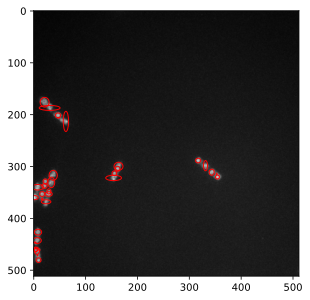

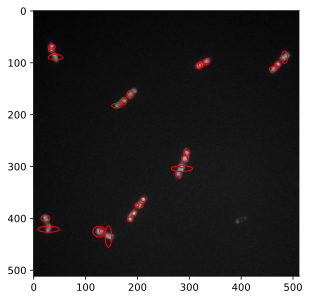

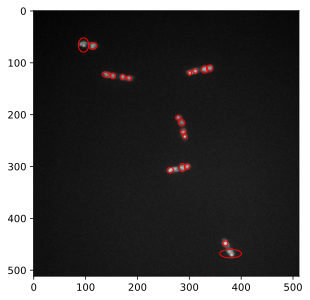

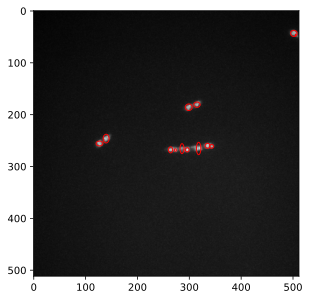

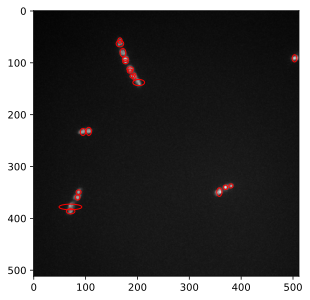

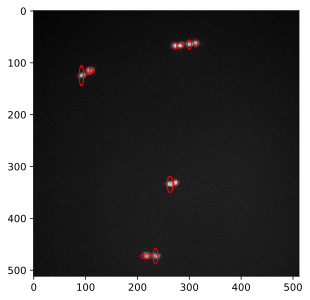

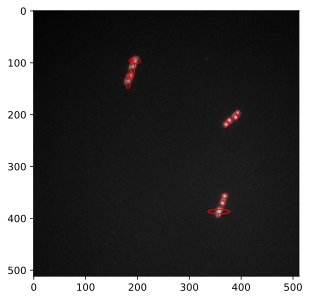

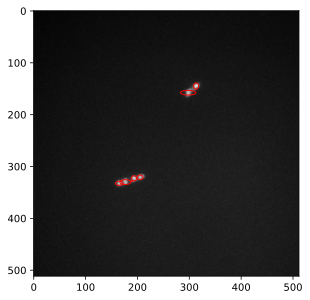

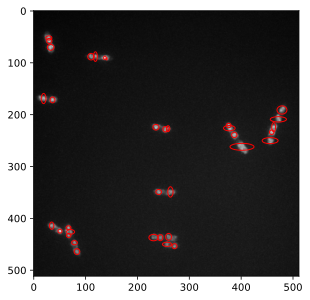

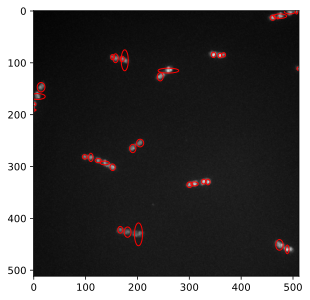

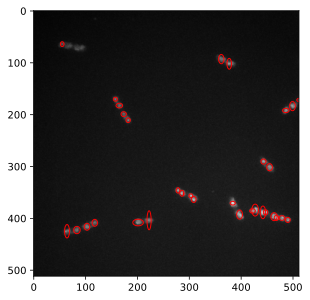

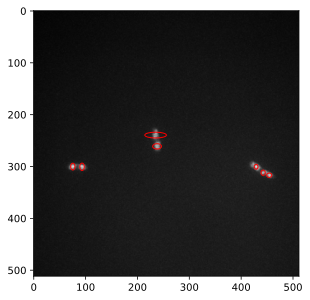

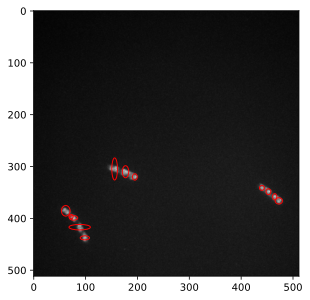

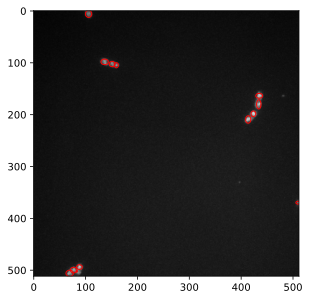

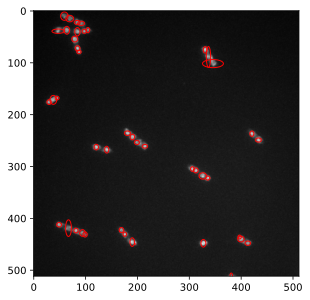

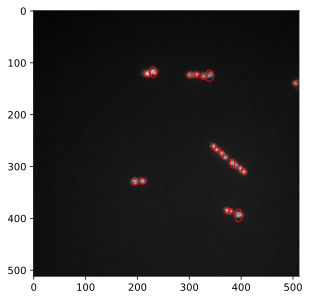

In [25]:
#run utility_batch_blob_detection on the hupa files
#blobs_hupa = utility_batch_blob_detection(files_hupa,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=True,plot=True)
#run utility_batch_blob_detection on the rpoc files
blobs_rpoc = utility_batch_blob_detection(files_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=True,plot=True)

In [ ]:
#redo the detection on the AML rpoC images with detection args with threshold changed 
detection_args_AML = detection_args.copy()
detection_args_AML["threshold"] = 1e-1
detection_args_AML["overlap"] = 0
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args_AML,fitting_args=fitting_args,focal_plane=3,project=False)


In [16]:

def get_blob_sizes(blobs,verbose=False):
    '''Return a flattened list of blob sizes
    
    Parameters:
    -----------
    blobs : list
        list of blobs detected in each image aggregated in a list
    verbose : bool
        True whether the blobs are Fitted and have sigma_x, and sigma_y. Or Flase if isotropic gaussian is used/Scale space (default is False)
    
    Returns:
    --------
    sizes : list
        list of blob sizes
    '''
    if verbose:
        return [np.concatenate([i[:,2] for i in blobs]).ravel(),np.concatenate([i[:,3] for i in blobs]).ravel()]
    else:
        return np.concatenate([i[:,2] for i in blobs]).ravel()
    


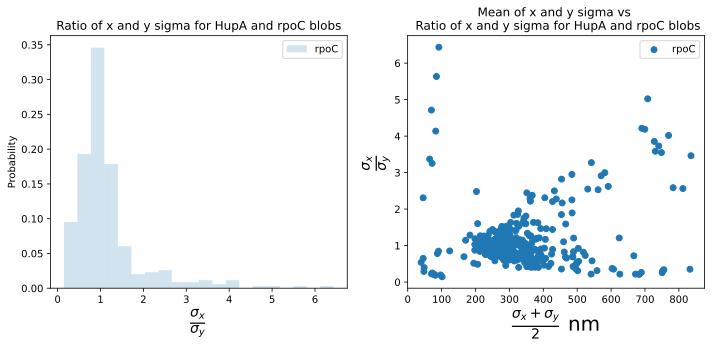

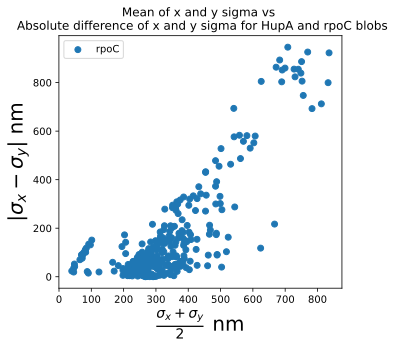

In [26]:
#sizes of the blobs if verbose is True, if false do not run this cell
#sizes_hupa = get_blob_sizes(blobs_hupa,verbose=True)
sizes_rpoc = get_blob_sizes(blobs_rpoc,verbose=True)
#sizes_aml_rpoc = get_blob_sizes(blobs_aml_rpoc,verbose=True)

#for each, find the ratio of the x and y sigma
#ratio_hupa = sizes_hupa[0]/sizes_hupa[1]
ratio_rpoc = sizes_rpoc[0]/sizes_rpoc[1]
#ratio_aml_rpoc = sizes_aml_rpoc[0]/sizes_aml_rpoc[1]

#plot the ratio of the x and y sigma as a histogram with the bins=20
#Make sure the weights are normalized

#make a figure with two subplots
fig,ax = plt.subplots(1,2,figsize=(10,5))
#redo the first plot on the first axis
#ax[0].hist(ratio_hupa,bins=20,weights=np.ones_like(ratio_hupa)/len(ratio_hupa),label="HupA",alpha=0.2)
ax[0].hist(ratio_rpoc,bins=20,weights=np.ones_like(ratio_rpoc)/len(ratio_rpoc),label="rpoC",alpha=0.2)
#ax[0].hist(ratio_aml_rpoc,bins=20,weights=np.ones_like(ratio_aml_rpoc)/len(ratio_aml_rpoc),label="AML rpoC",alpha=0.2)
ax[0].legend()
ax[0].set_xlabel(r"$\frac{\sigma_x}{\sigma_y}$",fontsize=20)
ax[0].set_ylabel("Probability")
ax[0].set_title("Ratio of x and y sigma for HupA and rpoC blobs")
#redo the second plot on the second axis
#find the mean of each x,y pair
#make sure to divide by sqrt(2) because of the blob_detection output scales the sigma by sqrt(2)

#mean_hupa = np.mean(sizes_hupa,axis=0)/np.sqrt(2)
mean_rpoc = np.mean(sizes_rpoc,axis=0)/np.sqrt(2)
#mean_aml_rpoc = np.mean(sizes_aml_rpoc,axis=0)/np.sqrt(2)

#plot the mean of the x and y sigma vs the ratios calculated above, make sure to multiply the mean by the confocal pixel size to get the correct units in nm
#ax[1].scatter(mean_hupa*globals["confocal_pixel_size"],ratio_hupa,label="HupA")
ax[1].scatter(mean_rpoc*globals["confocal_pixel_size"],ratio_rpoc,label="rpoC")
#ax[1].scatter(mean_aml_rpoc*globals["confocal_pixel_size"],ratio_aml_rpoc,label="AML rpoC")
ax[1].legend()
#write the the sigma as greek letters and make the font size of the labels bigger

ax[1].set_ylabel(r"$\frac{\sigma_x}{\sigma_y}$",fontsize=20)
ax[1].set_xlabel(r"$\frac{\sigma_x + \sigma_y}{2}$ nm",fontsize=20)
ax[1].set_title("Mean of x and y sigma vs \n Ratio of x and y sigma for HupA and rpoC blobs")
#make the plot look nice
plt.tight_layout()
plt.show()


#find the absolute differences in the x and y sigmas for each blob
#diff_hupa = np.abs(sizes_hupa[0]-sizes_hupa[1])/np.sqrt(2)
diff_rpoc = np.abs(sizes_rpoc[0]-sizes_rpoc[1])/np.sqrt(2)
#diff_aml_rpoc = np.abs(sizes_aml_rpoc[0]-sizes_aml_rpoc[1])/np.sqrt(2)

#plot this as a scatter plot vs the mean of the x and y sigmas
#make a figure with one subplot
fig,ax = plt.subplots(1,1,figsize=(5,5))
#plot the scatter plot
#ax.scatter(mean_hupa*globals["confocal_pixel_size"],diff_hupa*globals["confocal_pixel_size"],label="HupA")
ax.scatter(mean_rpoc*globals["confocal_pixel_size"],diff_rpoc*globals["confocal_pixel_size"],label="rpoC")
#ax.scatter(mean_aml_rpoc*globals["confocal_pixel_size"],diff_aml_rpoc*globals["confocal_pixel_size"],label="AML rpoC")
ax.legend()
#write the the sigma as greek letters and make the font size of the labels bigger
#the y label is the absolute difference of the x and y sigma
ax.set_ylabel(r"$\left|\sigma_x - \sigma_y\right|$ nm",fontsize=20)
ax.set_xlabel(r"$\frac{\sigma_x + \sigma_y}{2}$ nm",fontsize=20)
ax.set_title("Mean of x and y sigma vs \n Absolute difference of x and y sigma for HupA and rpoC blobs")
#make the plot look nice
plt.tight_layout()
plt.show()






In [ ]:
#change the detection parameter verbose to False to see the progress of the blob detection
detection_args["verbose"] = False

#run utility_batch_blob_detection on the hupa files
blobs_hupa = utility_batch_blob_detection(files_hupa,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the rpoc files
blobs_rpoc = utility_batch_blob_detection(files_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)
#run utility_batch_blob_detection on the aml rpoc files
blobs_aml_rpoc = utility_batch_blob_detection(files_aml_rpoc,detection_args=detection_args,fitting_args=fitting_args,focal_plane=3,project=False)


In [ ]:

#plot the two sizes on the same histogram plot with a legend and alpha transparency of 0.2, this does not work if verbose is True, do not run this cell if verbose is True
sizes_hupa = get_blob_sizes(blobs_hupa,verbose=False)
sizes_rpoc = get_blob_sizes(blobs_rpoc,verbose=False)
sizes_aml_rpoc = get_blob_sizes(blobs_aml_rpoc,verbose=False)

#make a figure with one subplot
plt.clf()
fig,ax = plt.subplots(1,1,figsize=(5,5))
#plot the histograms with the weights normaized to 1
ax.hist(sizes_hupa*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_hupa)/len(sizes_hupa),label="HupA",alpha=0.2)
ax.hist(sizes_rpoc*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_rpoc)/len(sizes_rpoc),label="rpoC",alpha=0.2)
ax.hist(sizes_aml_rpoc*globals["confocal_pixel_size"],bins=10,weights=np.ones_like(sizes_aml_rpoc)/len(sizes_aml_rpoc),label="AML rpoC",alpha=0.2)

#set the x and y labels
ax.set_xlabel("Size of blob (nm)")
ax.set_ylabel("Probaility")
#add a title
ax.set_title("Size of HupA and rpoC Blobs from Confocal Images")
#add an annotation for the mean and standard deviation for each distribution 
ax.annotate("HupA: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_hupa*globals["confocal_pixel_size"]),np.std(sizes_hupa*globals["confocal_pixel_size"])),xy=(0.05,0.9),xycoords="axes fraction")
ax.annotate("rpoC: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_rpoc*globals["confocal_pixel_size"]),np.std(sizes_rpoc*globals["confocal_pixel_size"])),xy=(0.05,0.85),xycoords="axes fraction")
ax.annotate("AML's rpoC: $\mu$ = {:.2f} nm, $\sigma$ = {:.2f} nm".format(np.mean(sizes_aml_rpoc*globals["confocal_pixel_size"]),np.std(sizes_aml_rpoc*globals["confocal_pixel_size"])),xy=(0.05,0.75),xycoords="axes fraction")
#annotate the result of a ks test both the p value and the statistic
ax.annotate("K-S Test: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]),xy=(0.05,0.8),xycoords="axes fraction")
#make the legend in the middle right of the plot
ax.legend(loc="center left")
plt.show()
print(np.max(sizes_hupa*globals["confocal_pixel_size"]))
print(np.min(sizes_hupa*globals["confocal_pixel_size"]))

In [ ]:
#find the mean and standard deviation of the hupa and rpoc blobs
print("HupA: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_hupa*globals["confocal_pixel_size"]),np.std(sizes_hupa*globals["confocal_pixel_size"])))
print("rpoC: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_rpoc*globals["confocal_pixel_size"]),np.std(sizes_rpoc*globals["confocal_pixel_size"])))
#do the same for the aml rpoc blobs
print("AML's rpoC: mean = {:.2f} nm, std = {:.2f} nm".format(np.mean(sizes_aml_rpoc*globals["confocal_pixel_size"]),np.std(sizes_aml_rpoc*globals["confocal_pixel_size"])))
#find the p value and the statistic of the ks test
print("K-S Test: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))

#test if the two rpoc distributions are from the same distribution
print("K-S Test for rpoC and AML's rpoC: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_rpoc*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_rpoc*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[0]))

#test if AML's rpoC and HupA are from the same distribution
print("K-S Test for AML's rpoC and HupA: p_val = {:.2e}, D = {:.2f}".format(stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[1],stats.ks_2samp(sizes_hupa*globals["confocal_pixel_size"],sizes_aml_rpoc*globals["confocal_pixel_size"])[0]))

#Statistics 
#perform a wilcoxon rank sum test on the hupa and rpoc blobs
print("Wilcoxon Rank Sum Test: p_val = {:.2e}, W = {:.2f}".format(stats.ranksums(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.ranksums(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))
#perform a mann whitney u test on the hupa and rpoc blobs
print("Mann Whitney U Test: p_val = {:.2e}, U = {:.2f}".format(stats.mannwhitneyu(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[1],stats.mannwhitneyu(sizes_hupa*globals["confocal_pixel_size"],sizes_rpoc*globals["confocal_pixel_size"])[0]))

#check if the hupa and rpoc blobs are normally distributed
print("HupA: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_hupa*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_hupa*globals["confocal_pixel_size"]),stats.kurtosis(sizes_hupa*globals["confocal_pixel_size"])))
print("rpoC: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_rpoc*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_rpoc*globals["confocal_pixel_size"]),stats.kurtosis(sizes_rpoc*globals["confocal_pixel_size"])))
#check if the aml rpoc blobs are normally distributed
print("AML's rpoC: normal = {}, skew = {:.2f}, kurtosis = {:.2f}".format(stats.normaltest(sizes_aml_rpoc*globals["confocal_pixel_size"])[1]>0.05,stats.skew(sizes_aml_rpoc*globals["confocal_pixel_size"]),stats.kurtosis(sizes_aml_rpoc*globals["confocal_pixel_size"])))

#find the number of blobs in the hupa and rpoc files
print("HupA: number of blobs = {}".format(len(sizes_hupa)))
print("rpoC: number of blobs = {}".format(len(sizes_rpoc)))

#find the number of blobs in each file
print("HupA: number of blobs per file = {}".format([len(i) for i in blobs_hupa]))
print("rpoC: number of blobs per file = {}".format([len(i) for i in blobs_rpoc]))

#create a QQ plot for both the hupa and rpoc blobs to check if they are normally distributed. Do this on the same plot
plt.clf()
stats.probplot(sizes_hupa*globals["confocal_pixel_size"],dist="norm",plot=plt)
stats.probplot(sizes_rpoc*globals["confocal_pixel_size"],dist="norm",plot=plt)
#do this for the aml rpoc blobs
stats.probplot(sizes_aml_rpoc*globals["confocal_pixel_size"],dist="norm",plot=plt)
#annotate the two datasets with rpoc and hupa labels, make the text bold and readable at a distance
plt.annotate("HupA",xy=(0.05,0.35),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.annotate("rpoC",xy=(0.05,0.18),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.annotate("AML's rpoC",xy=(0.05,0.01),xycoords="axes fraction",fontweight="bold",fontsize=16)
plt.show()




